# Link prediction with GraphSAGE

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In this example, we use our implementation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to build a model that predicts citation links in the Cora dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GraphSAGE model that takes labeled node pairs (`citing-paper` -> `cited-paper`)  corresponding to possible citation links, and outputs a pair of node embeddings for the `citing-paper` and `cited-paper` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

2022-04-07 11:10:22.675630: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 11:10:23.494066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22306 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-04-07 11:10:23.494720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21811 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the CORA network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [8]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4399

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4399]
        Weights: all 1 (default)
        Features: none


In [9]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4887

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4887]
        Weights: all 1 (default)
        Features: none


Next, we create the link generators for sampling and streaming train and test link examples to the model. The link generators essentially "map" pairs of nodes (`citing-paper`, `cited-paper`) to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with (`citing-paper`, `cited-paper`) head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [10]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE. Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model:

In [11]:
num_samples = [20, 10]

For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method. The `shuffle=True` argument is given to the `flow` method to improve training.

In [12]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

At test time we use the `G_test` graph and don't specify the `shuffle` argument (it defaults to `False`).

In [13]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated (`citing-paper`, `cited-paper`) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the GraphSAGE model.

In [14]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [15]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

Final link classification layer that takes a pair of node embeddings produced by GraphSAGE, applies a binary operator to them to produce the corresponding link embedding (`ip` for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [16]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Evaluate the initial (untrained) model on the train and test set:

In [18]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

 5/49 [==>...........................] - ETA: 1s - loss: 0.7637 - acc: 0.6300 

2022-04-07 11:10:27.695792: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


55/55 [==============================] - 3s 55ms/step - loss: 0.9432 - acc: 0.6347

Train Set Metrics of the initial (untrained) model:
	loss: 0.8188
	acc: 0.6127

Test Set Metrics of the initial (untrained) model:
	loss: 0.9432
	acc: 0.6347


Train the model:

In [19]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
49/49 - 7s - loss: 0.8300 - acc: 0.5973 - val_loss: 0.6442 - val_acc: 0.6375 - 7s/epoch - 136ms/step
Epoch 2/20
49/49 - 6s - loss: 0.5692 - acc: 0.7336 - val_loss: 0.5137 - val_acc: 0.7482 - 6s/epoch - 116ms/step
Epoch 3/20
49/49 - 5s - loss: 0.4625 - acc: 0.8053 - val_loss: 0.5129 - val_acc: 0.7472 - 5s/epoch - 104ms/step
Epoch 4/20
49/49 - 6s - loss: 0.4022 - acc: 0.8432 - val_loss: 0.4776 - val_acc: 0.7924 - 6s/epoch - 115ms/step
Epoch 5/20
49/49 - 5s - loss: 0.3422 - acc: 0.8617 - val_loss: 0.4529 - val_acc: 0.8044 - 5s/epoch - 109ms/step
Epoch 6/20
49/49 - 6s - loss: 0.2936 - acc: 0.9057 - val_loss: 0.4635 - val_acc: 0.8137 - 6s/epoch - 115ms/step
Epoch 7/20
49/49 - 6s - loss: 0.2660 - acc: 0.9262 - val_loss: 0.4658 - val_acc: 0.8164 - 6s/epoch - 119ms/step
Epoch 8/20
49/49 - 6s - loss: 0.2745 - acc: 0.9201 - val_loss: 0.4505 - val_acc: 0.8164 - 6s/epoch - 113ms/step
Epoch 9/20
49/49 - 5s - loss: 0.2586 - acc: 0.9273 - val_loss: 0.4892 - val_acc: 0.8183 - 5s/epoch - 107

Plot the training history:

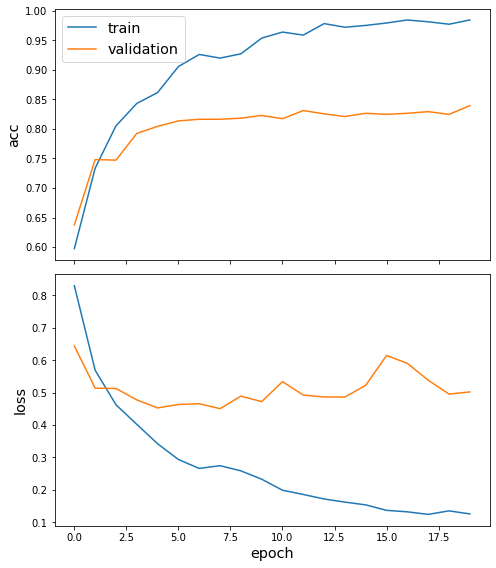

In [20]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [25]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

55/55 [==============================] - 3s 55ms/step - loss: 0.5329 - acc: 0.8330

Train Set Metrics of the trained model:
	loss: 0.0574
	acc: 0.9959

Test Set Metrics of the trained model:
	loss: 0.5329
	acc: 0.8330


In [38]:
train_metrics[0][0]

TypeError: 'float' object is not subscriptable

In [26]:
train_metrics

[0.05736740678548813, 0.9959016442298889]

In [27]:
model.metrics_names

['loss', 'acc']

In [28]:
test_metrics

[0.5329458117485046, 0.8330258131027222]

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>